### NLP Classification Project

##### Building a spam filter with the kernel framework. 

Emails are either classed as undersired "spam" or "ham". This classification task is applies and uses variants of edit distance within a kernel framework. LibSVM algorithm is then applied to clasify the data as either "ham" or "spam". The <a href = "https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection">SMS Spam Collection Data Set</a> from UCI machine learning repository 

* Clean the data
* Carry out data exploration
* split, tokenize, remove punctuation
* Extract features
* Construct kernels
* Run classification 
* Compare and analyse

In [1]:
#Import required files
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re
import string
from zipfile import ZipFile 
import requests
from libsvm.svmutil import *
from util_ker import *
from util_ker import EvaluateTest
from util_Text import *
from util_prob import *
from LogUtil import *
import seaborn as sns
import time

%matplotlib inline
pd.set_option('display.max_colwidth', 100)

### Download Data

In [2]:
#download 'smsspamcollection.zip' files from UCI website (file is a zipped file )
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
r = requests.get(url, allow_redirects=True)
open('smsspamcollection.zip', 'wb').write(r.content)
fname = 'smsspamcollection.zip'

In [3]:
#Extract the zipped file
with ZipFile(fname, 'r') as nip: 
    nip.printdir() 
     
    nip.extractall() 
    print('Extraction Complete!') 

File Name                                             Modified             Size
SMSSpamCollection                              2011-03-15 22:36:02       477907
readme                                         2011-04-18 14:53:56         5868
Extraction Complete!


In [4]:
#Load Data
data = pd.read_csv("./SMSSpamCollection", sep='\t', header=None, names=['label','Text'])

In [5]:
data.head()

,label,Text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [6]:
print(f'The data is made up of {data.shape[0]} examples ')

The data is made up of 5572 examples 


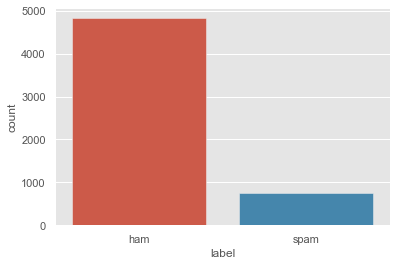

In [7]:
sns.countplot(data.label)
plt.show()

In [8]:
len_ham  = data[data['label']=='ham'].count()[0]
len_spam = data[data['label']=='spam'].count()[0]
print(f'{len_ham} examples classed as ham. {len_spam} examples classed as spam')

4825 examples classed as ham. 747 examples classed as spam


# Uneven Length Sequences

In [9]:
#Extract the length of each example
lenData = np.zeros((len(data),1))
for i in range(len(data)):
    lenData[i] = len(data.Text[i])

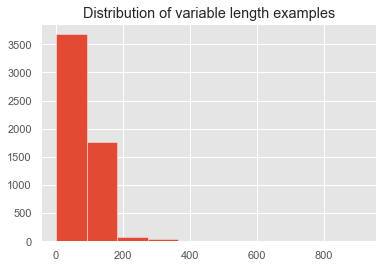

In [10]:
#Plot a histogram showing the distribution of the variable length
plt.hist(lenData);
plt.title('Distribution of variable length examples');

### Clean Data

 - Remove punctuation
 - Tokenize the strings
 - Remove stop words

In [11]:
data['Text_cleaned'] = data['Text'].apply(lambda x: clean_text(x)) #Applies the function to each row
data.head(10)

,label,Text,Text_cleaned
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...","[Go, jurong, point, crazy, Available, bugis, n, great, world, la, e, buffet, Cine, got, amore, wat]"
1,ham,Ok lar... Joking wif u oni...,"[Ok, lar, Joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,"[Free, entry, 2, wkly, comp, win, FA, Cup, final, tkts, 21st, May, 2005, Text, FA, 87121, receiv..."
3,ham,U dun say so early hor... U c already then say...,"[U, dun, say, early, hor, U, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives around here though","[Nah, I, dont, think, goes, usf, lives, around, though]"
5,spam,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for ...,"[FreeMsg, Hey, darling, 3, weeks, word, back, Id, like, fun, still, Tb, ok, XxX, std, chgs, send..."
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.,"[Even, brother, like, speak, They, treat, like, aids, patent]"
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your call...,"[As, per, request, Melle, Melle, Oru, Minnaminunginte, Nurungu, Vettam, set, callertune, Callers..."
8,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To c...,"[WINNER, As, valued, network, customer, selected, receivea, 900, prize, reward, To, claim, call,..."
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with came...,"[Had, mobile, 11, months, U, R, entitled, Update, latest, colour, mobiles, camera, Free, Call, T..."


### Apply Stemming

In [12]:
# ['Porter','Lancaster']
Stemmer = 'Porter'

In [13]:
data['Text_stemmed'] = data['Text_cleaned'].apply(lambda x: stemming(x,Stemmer))
data.head()

,label,Text,Text_cleaned,Text_stemmed
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...","[Go, jurong, point, crazy, Available, bugis, n, great, world, la, e, buffet, Cine, got, amore, wat]","[Go, jurong, point, crazi, avail, bugi, n, great, world, la, e, buffet, cine, got, amor, wat]"
1,ham,Ok lar... Joking wif u oni...,"[Ok, lar, Joking, wif, u, oni]","[Ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,"[Free, entry, 2, wkly, comp, win, FA, Cup, final, tkts, 21st, May, 2005, Text, FA, 87121, receiv...","[free, entri, 2, wkli, comp, win, FA, cup, final, tkt, 21st, may, 2005, text, FA, 87121, receiv,..."
3,ham,U dun say so early hor... U c already then say...,"[U, dun, say, early, hor, U, c, already, say]","[U, dun, say, earli, hor, U, c, alreadi, say]"
4,ham,"Nah I don't think he goes to usf, he lives around here though","[Nah, I, dont, think, goes, usf, lives, around, though]","[nah, I, dont, think, goe, usf, live, around, though]"


### Lemmatize the data

In [14]:
data['Text_lemmatized'] = data['Text_stemmed'].apply(lambda x: lemmatizing(x))

data.head()

,label,Text,Text_cleaned,Text_stemmed,Text_lemmatized
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...","[Go, jurong, point, crazy, Available, bugis, n, great, world, la, e, buffet, Cine, got, amore, wat]","[Go, jurong, point, crazi, avail, bugi, n, great, world, la, e, buffet, cine, got, amor, wat]","[Go, jurong, point, crazi, avail, bugi, n, great, world, la, e, buffet, cine, got, amor, wat]"
1,ham,Ok lar... Joking wif u oni...,"[Ok, lar, Joking, wif, u, oni]","[Ok, lar, joke, wif, u, oni]","[Ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,"[Free, entry, 2, wkly, comp, win, FA, Cup, final, tkts, 21st, May, 2005, Text, FA, 87121, receiv...","[free, entri, 2, wkli, comp, win, FA, cup, final, tkt, 21st, may, 2005, text, FA, 87121, receiv,...","[free, entri, 2, wkli, comp, win, FA, cup, final, tkt, 21st, may, 2005, text, FA, 87121, receiv,..."
3,ham,U dun say so early hor... U c already then say...,"[U, dun, say, early, hor, U, c, already, say]","[U, dun, say, earli, hor, U, c, alreadi, say]","[U, dun, say, earli, hor, U, c, alreadi, say]"
4,ham,"Nah I don't think he goes to usf, he lives around here though","[Nah, I, dont, think, goes, usf, lives, around, though]","[nah, I, dont, think, goe, usf, live, around, though]","[nah, I, dont, think, goe, usf, live, around, though]"


### Change labels from ham to -1 and spam to 1

In [15]:
data.replace({'label': {'ham': 0, 'spam': 1}}, inplace=True)

In [16]:
data.tail()

,label,Text,Text_cleaned,Text_stemmed,Text_lemmatized
5567,1,This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy...,"[This, 2nd, time, tried, 2, contact, u, U, 750, Pound, prize, 2, claim, easy, call, 087187272008...","[thi, 2nd, time, tri, 2, contact, u, U, 750, pound, prize, 2, claim, easi, call, 087187272008, n...","[thi, 2nd, time, tri, 2, contact, u, U, 750, pound, prize, 2, claim, easi, call, 087187272008, n..."
5568,0,Will ü b going to esplanade fr home?,"[Will, ü, b, going, esplanade, fr, home]","[will, ü, b, go, esplanad, fr, home]","[will, ü, b, go, esplanad, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other suggestions?","[Pity, mood, Soany, suggestions]","[piti, mood, soani, suggest]","[piti, mood, soani, suggest]"
5570,0,The guy did some bitching but I acted like i'd be interested in buying something else next week ...,"[The, guy, bitching, I, acted, like, id, interested, buying, something, else, next, week, gave, ...","[the, guy, bitch, I, act, like, id, interest, buy, someth, els, next, week, gave, us, free]","[the, guy, bitch, I, act, like, id, interest, buy, someth, el, next, week, gave, u, free]"
5571,0,Rofl. Its true to its name,"[Rofl, Its, true, name]","[rofl, it, true, name]","[rofl, it, true, name]"


In [17]:
sample=78 #Change to view sample data

print('\033[92m')
print(data.Text[sample])
print('\033[90m'+ 'Raw_Text')

print('\033[94m')
print(data.Text_cleaned[sample])
print('\033[90m'+ 'Cleaned to tokenize, remove punctuation and stopwords')

print('\033[96m')
print(data.Text_stemmed[sample])
print('\033[90m'+ 'Stemmed with Porter stemmer')

print('\033[91m')
print(data.Text_lemmatized[sample])
print('\033[90m'+ 'Lemmatized with WordNetLemmatizer')


Does not operate after  &lt;#&gt;  or what
Raw_Text

['Does', 'operate', 'ltgt']
Cleaned to tokenize, remove punctuation and stopwords

['doe', 'oper', 'ltgt']
Stemmed with Porter stemmer

['doe', 'oper', 'ltgt']
Lemmatized with WordNetLemmatizer


### Extract predictor variables and target label

In [18]:
Y = data.label.values.reshape(len(data),1)
X = data.Text_stemmed.values.reshape(len(Y),1)  #data.iloc[:,4].values.shape

In [19]:
# Split data into Training, Test and Validation data sets
xtr, xva, xte, ytr, yva, yte = splitdata(X, Y, 18, 0.60)

3343 training examples and 1 features
1114 validation examples and 1 features
1115 testing examples and 1 features


Training set has 431 positive and 2912 negative labels
Validation set has 168 positive and 946 negative labels
Test set has 148 positive and 967 negative labels




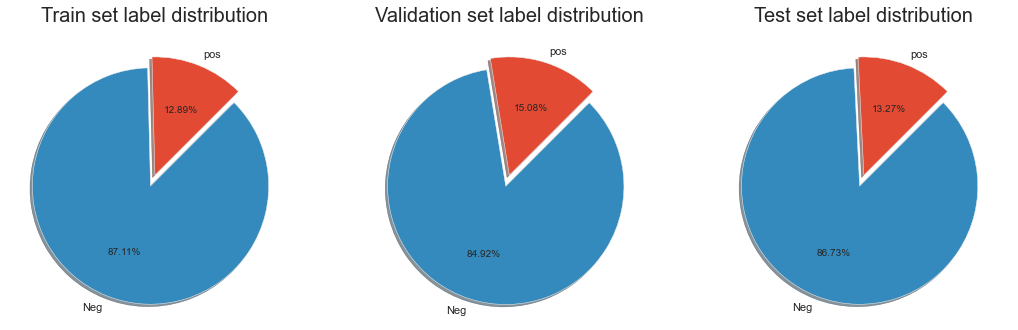

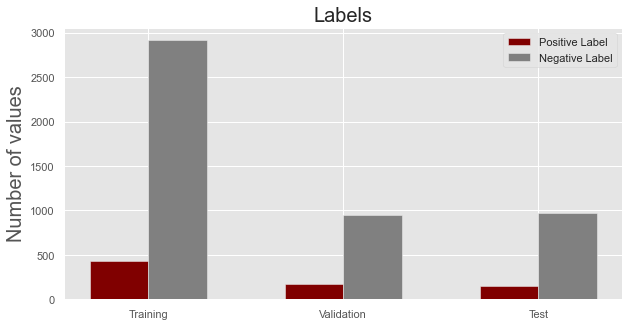

In [20]:
plot_dataset_distrib(xtr, xva, xte, ytr, yva, yte)

In [21]:
xtr2=xtr
xva2=xva

## Build Probabilistic Model
We test generating a data frequency dictionary with samples from the training set. We assume this will be the only data available to us. Then possibly we update the dictionay and retest to see if this has any effects. 

In [22]:
data_freq = build_freq(xtr, ytr)

In [23]:
len(data_freq)

7041

In [24]:
print(data_freq)

{('Im', 0): 177, ('viveki', 0): 1, ('got', 0): 156, ('call', 0): 179, ('number', 0): 38, ('from', 0): 7, ('someon', 0): 30, ('smoke', 0): 14, ('everi', 0): 27, ('time', 0): 135, ('ive', 0): 52, ('last', 0): 33, ('two', 0): 19, ('week', 0): 41, ('text', 0): 54, ('want', 0): 134, ('ultim', 0): 1, ('tor', 0): 1, ('motiv', 0): 2, ('tui', 0): 1, ('achiev', 0): 1, ('korli', 0): 1, ('you', 0): 134, ('shitload', 0): 2, ('diamond', 0): 2, ('though', 0): 16, ('it', 0): 77, ('cool', 0): 22, ('littl', 0): 13, ('get', 0): 219, ('soon', 0): 40, ('what', 0): 81, ('u', 0): 462, ('wear', 0): 5, ('haha', 0): 29, ('where', 0): 27, ('fast', 0): 9, ('lose', 0): 19, ('weight', 0): 5, ('thk', 0): 24, ('muz', 0): 9, ('go', 0): 239, ('4', 0): 104, ('month', 0): 24, ('den', 0): 20, ('effect', 0): 3, ('geelat', 0): 1, ('aust', 0): 1, ('put', 0): 19, ('bk', 0): 1, ('e', 0): 45, ('unfortun', 0): 2, ('found', 0): 12, ('pick', 0): 48, ('sister', 0): 13, ('airport', 0): 3, ('even', 0): 50, ('dont', 0): 181, ('think',

In [25]:
data_freq2 = build_freq(X, Y)

In [26]:
len(data_freq2)

9308

View a sample example of the data transformation with the number of positive and negative occurence of each word displayed in a table

In [27]:
#Obtain an example
sample = set(xtr[217][0])

In [28]:
data_table =[]
for text in sample:
    pos = 0
    neg = 0
    
    if (text, 1) in data_freq:
        pos=data_freq[(text, 1)]
    
    if (text, 0) in data_freq:
        neg = data_freq[(text,0)]
        
    data_table.append([text, pos, neg])   

In [29]:
pd.DataFrame(data_table, columns=["word","num_pos","num_neg"])

,word,num_pos,num_neg
0,m263uz,2,0
1,offer,21,6
2,16,34,1
3,sub,7,2
4,voucher,18,1
5,150,27,0
6,300,8,0
7,discount,5,2
8,worth,9,3
9,text,89,54


### Show a plot showing the data split into two classes

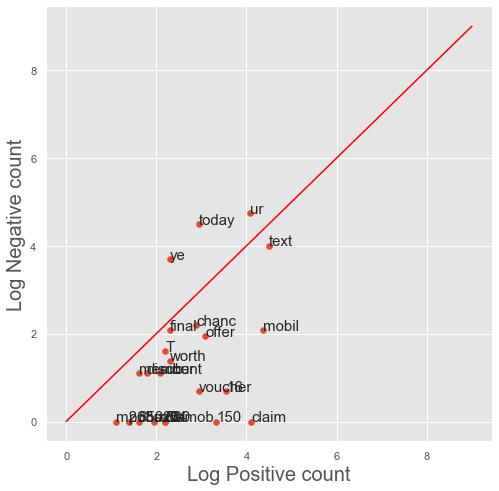

In [30]:
fig, ax = plt.subplots(figsize = (8, 8))

x = np.log([x[1] + 1 for x in data_table])  #1 added to avoid log(0)
y = np.log([x[2] + 1 for x in data_table]) 

ax.scatter(x, y)  #scatter plot of negative and positive count

# assign axis labels
plt.xlabel("Log Positive count", fontsize=20)
plt.ylabel("Log Negative count", fontsize=20)

for i in range(0, len(data_table)): #Annotate the scatter plot with corresponding word
    ax.annotate(data_table[i][0], (x[i], y[i]), fontsize=15)

ax.plot([0, 9], [0, 9], color = 'red') # red line to divide the 2 areas.
plt.show()

## Extract positive and negative features

In [31]:
#pos_neg_data = []

#for i in range(0,len(X)):
#    pos_neg_data.append(extract_pos_neg_features1(X[i][0], data_freq))

In [32]:
#pd.DataFrame(np.squeeze(pos_neg_data))

In [33]:
pos_neg_data = []

for i in range(0,len(xtr)):
    pos_neg_data.append(extract_pos_neg_features1(xtr[i][0], data_freq))

xtr = np.squeeze(pos_neg_data)
ytr = np.squeeze(ytr)
pd.DataFrame(np.squeeze(pos_neg_data))

,0,1
0,245.0,551.0
1,414.0,725.0
2,1.0,7.0
3,59.0,310.0
4,74.0,539.0
...,...,...
3338,7.0,98.0
3339,139.0,2170.0
3340,40.0,1192.0
3341,12.0,473.0


In [34]:
pos_neg_data = []

for i in range(0,len(xte)):
    pos_neg_data.append(extract_pos_neg_features1(xte[i][0], data_freq))

xte = np.squeeze(pos_neg_data)
yte = np.squeeze(yte)
pd.DataFrame(np.squeeze(pos_neg_data))

,0,1
0,629.0,584.0
1,140.0,153.0
2,107.0,1509.0
3,28.0,215.0
4,50.0,639.0
...,...,...
1110,112.0,1404.0
1111,12.0,203.0
1112,44.0,272.0
1113,546.0,693.0


In [35]:
pos_neg_data = []

for i in range(0,len(xva)):
    pos_neg_data.append(extract_pos_neg_features1(xva[i][0], data_freq))

xva = np.squeeze(pos_neg_data)
yva = np.squeeze(yva)
pd.DataFrame(np.squeeze(pos_neg_data))

,0,1
0,57.0,277.0
1,67.0,1423.0
2,90.0,1225.0
3,23.0,524.0
4,23.0,896.0
...,...,...
1109,13.0,357.0
1110,57.0,194.0
1111,64.0,333.0
1112,23.0,502.0


In [36]:
xtr, xva, xte = xtr.T, xva.T, xte.T

In [37]:
n = ytr.shape[0]
ytr=ytr.reshape(1,n)
ytr.shape

(1, 3343)

In [38]:
n = yte.shape[0]
yte=yte.reshape(1,n)
yte.shape

(1, 1115)

In [39]:
n = yva.shape[0]
yva=yva.reshape(1,n)
yva.shape

(1, 1114)

# Run Logistic Regression

In [40]:
w,b = initalise_parameters(xtr)

In [41]:
grads, cost = propagate(w, b, xtr, ytr)

### Normalize data

In [42]:
x_Mean = np.mean(xtr, axis=1)
x_Mean.reshape(2,1)

array([[117.57792402],
       [640.37660784]])

In [43]:
x_std = np.std(xtr, axis=1)
x_std.reshape(2,1)

array([[152.2341206 ],
       [540.07369038]])

In [44]:
xtr_norm = (xtr - x_Mean.reshape(2,1))/x_std.reshape(2,1)
xte_norm = (xte - x_Mean.reshape(2,1))/x_std.reshape(2,1)
xva_norm = (xva - x_Mean.reshape(2,1))/x_std.reshape(2,1)

In [45]:
params, grads, costs = optimize(w, b, xtr_norm, ytr, 100000, learning_rate=0.0009, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 10000: 0.214344
Cost after iteration 20000: 0.161635
Cost after iteration 30000: 0.142990
Cost after iteration 40000: 0.133594
Cost after iteration 50000: 0.127996
Cost after iteration 60000: 0.124322
Cost after iteration 70000: 0.121755
Cost after iteration 80000: 0.119879
Cost after iteration 90000: 0.118465


In [46]:
w = params['w']
b = params['b']

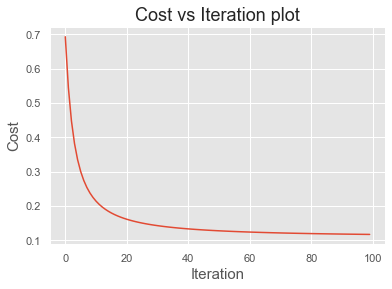

In [47]:
plt.plot(costs)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.title("Cost vs Iteration plot", fontsize=18)
plt.show()

### Make Predictions

In [48]:
Y_prediction_Val, A_Val   = predict(w, b, xva_norm)
Y_prediction_Train, A_Train = predict(w, b, xtr_norm)

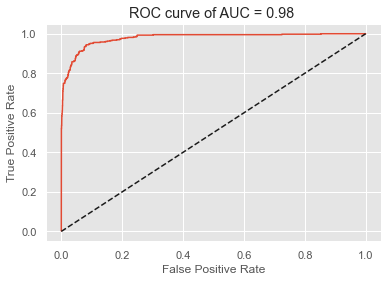

--> An AUC value of 0.98 achieved


In [49]:
compute_Roc(ytr, A_Train)

--> The total of 3343 predicted with only 3205 accurate predictions

Ground Truth comparison

Actual label is True while we predicted True   -  True Positive  =  327
Actual label is False while we predicted False -  True Negatve   =  2878
Actual label is False while we predicted True  -  False Positive =  34
Actual label is True while we predicted False  -  False Negative =  104


--> 361 positive outcomes predicted
--> 2982 negative outcomes predicted
--> An accuracy of 95.87 % was achieved
--> Sensitity of 0.76 was achieved
--> Specificity of 0.99 was achieved 
--> 0.11 rate of positive prediction
--> 0.89 rate of negative prediction
--> 0.24 false negative rate was achieved
--> 0.01 false positve rate (fallout) was achieved
--> Negative predictive value of 0.97
--> Recall value 0f 0.76 achieved
--> The precision vaue of 0.91 achieved
--> An Fscore of 0.83 achieved


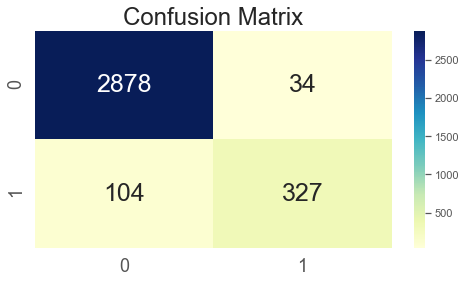

In [50]:
eva_train=EvaluateTest(ytr.T, Y_prediction_Train.T)

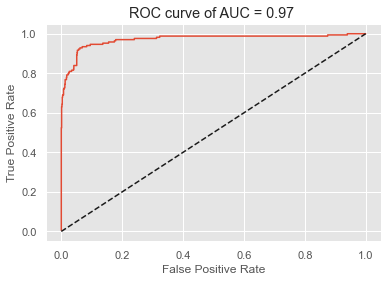

--> An AUC value of 0.97 achieved


In [51]:
compute_Roc(yva, A_Val)

--> The total of 1114 predicted with only 1059 accurate predictions

Ground Truth comparison

Actual label is True while we predicted True   -  True Positive  =  122
Actual label is False while we predicted False -  True Negatve   =  937
Actual label is False while we predicted True  -  False Positive =  9
Actual label is True while we predicted False  -  False Negative =  46


--> 131 positive outcomes predicted
--> 983 negative outcomes predicted
--> An accuracy of 95.06 % was achieved
--> Sensitity of 0.73 was achieved
--> Specificity of 0.99 was achieved 
--> 0.12 rate of positive prediction
--> 0.88 rate of negative prediction
--> 0.27 false negative rate was achieved
--> 0.01 false positve rate (fallout) was achieved
--> Negative predictive value of 0.95
--> Recall value 0f 0.73 achieved
--> The precision vaue of 0.93 achieved
--> An Fscore of 0.82 achieved


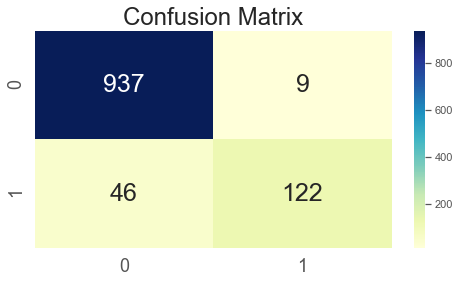

In [52]:
eva_valid=EvaluateTest(yva.T, Y_prediction_Val.T)

In [53]:
print("Train accuracy: {}".format(100 - np.mean(np.abs(Y_prediction_Train - ytr)) * 100))
print("Val accuracy: {}".format(100 - np.mean(np.abs(Y_prediction_Val - yva)) * 100))

Train accuracy: 95.8719712832785
Val accuracy: 95.06283662477558


Train accuracy: 95.36970567121321 %
Val accuracy: 96.41062455132807 %
Test accuracy: 95.76453697056712 %


# Test with dictionary developed from entire dataset

In [54]:
pos_neg_data = []

for i in range(0,len(xtr2)):
    pos_neg_data.append(extract_pos_neg_features1(xtr2[i][0], data_freq2))

xtr2 = np.squeeze(pos_neg_data)
pd.DataFrame(np.squeeze(pos_neg_data))

,0,1
0,429.0,891.0
1,696.0,1172.0
2,1.0,8.0
3,109.0,476.0
4,131.0,891.0
...,...,...
3338,12.0,150.0
3339,240.0,3514.0
3340,62.0,1912.0
3341,24.0,760.0


In [55]:
pos_neg_data = []

for i in range(0,len(xva2)):
    pos_neg_data.append(extract_pos_neg_features1(xva2[i][0], data_freq2))

xva2 = np.squeeze(pos_neg_data)
pd.DataFrame(np.squeeze(pos_neg_data))

,0,1
0,99.0,467.0
1,99.0,2291.0
2,165.0,1990.0
3,35.0,884.0
4,39.0,1473.0
...,...,...
1109,25.0,596.0
1110,108.0,317.0
1111,112.0,565.0
1112,37.0,832.0


In [56]:
xtr2=xtr2.T
xva2=xva2.T

In [57]:
x_Mean = np.mean(xtr2, axis=1)
x_Mean.reshape(2,1)

array([[ 202.80765779],
       [1041.11935387]])

In [58]:
x_std = np.std(xtr2, axis=1)
x_std.reshape(2,1)

array([[261.92587048],
       [878.63752577]])

In [59]:
xtr_norm2 = (xtr2 - x_Mean.reshape(2,1))/x_std.reshape(2,1)
#xte_norm = (xte - x_Mean.reshape(2,1))/x_std.reshape(2,1)
xva_norm2 = (xva2 - x_Mean.reshape(2,1))/x_std.reshape(2,1)

In [60]:
w2,b2 = initalise_parameters(xtr2)

In [61]:
params, grads, costs = optimize(w2, b2, xtr_norm2, ytr, 100000, learning_rate=0.0009, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 10000: 0.217199
Cost after iteration 20000: 0.165050
Cost after iteration 30000: 0.146683
Cost after iteration 40000: 0.137457
Cost after iteration 50000: 0.131976
Cost after iteration 60000: 0.128387
Cost after iteration 70000: 0.125884
Cost after iteration 80000: 0.124058
Cost after iteration 90000: 0.122684


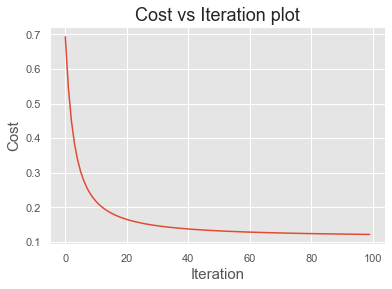

In [62]:
plt.plot(costs)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.title("Cost vs Iteration plot", fontsize=18)
plt.show()

In [63]:
Y_prediction_Val2, A_Val2     = predict(w2, b2, xva_norm2)
Y_prediction_Train2, A_Train2 = predict(w2, b2, xtr_norm2)

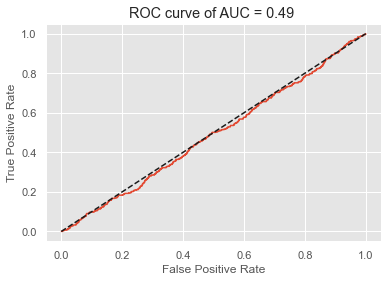

--> An AUC value of 0.49 achieved


In [64]:
compute_Roc(ytr, A_Train2)

--> The total of 3343 predicted with only 2912 accurate predictions

Ground Truth comparison

Actual label is True while we predicted True   -  True Positive  =  0
Actual label is False while we predicted False -  True Negatve   =  2912
Actual label is False while we predicted True  -  False Positive =  0
Actual label is True while we predicted False  -  False Negative =  431

No True positives or False positives predicted
Fscore cannot be calculated as denominator is 0

--> 0 positive outcomes predicted
--> 3343 negative outcomes predicted
--> An accuracy of 87.11 % was achieved
--> Sensitity of 0.0 was achieved
--> Specificity of 1.0 was achieved 
--> 0.0 rate of positive prediction
--> 1.0 rate of negative prediction
--> 1.0 false negative rate was achieved
--> 0.0 false positve rate (fallout) was achieved
--> Negative predictive value of 0.87
--> Recall value 0f 0.0 achieved
--> The precision vaue of 0 achieved
--> An Fscore of 0 achieved


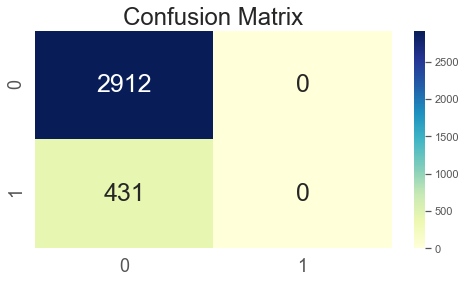

In [65]:
eva_train2=EvaluateTest(ytr.T, Y_prediction_Train2.T)

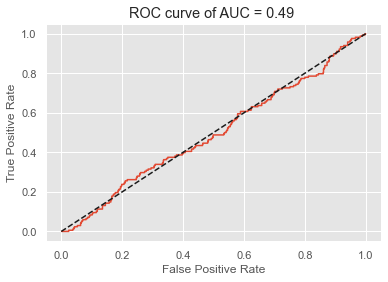

--> An AUC value of 0.49 achieved


In [66]:
compute_Roc(yva, A_Val2)

--> The total of 1114 predicted with only 946 accurate predictions

Ground Truth comparison

Actual label is True while we predicted True   -  True Positive  =  0
Actual label is False while we predicted False -  True Negatve   =  946
Actual label is False while we predicted True  -  False Positive =  0
Actual label is True while we predicted False  -  False Negative =  168

No True positives or False positives predicted
Fscore cannot be calculated as denominator is 0

--> 0 positive outcomes predicted
--> 1114 negative outcomes predicted
--> An accuracy of 84.92 % was achieved
--> Sensitity of 0.0 was achieved
--> Specificity of 1.0 was achieved 
--> 0.0 rate of positive prediction
--> 1.0 rate of negative prediction
--> 1.0 false negative rate was achieved
--> 0.0 false positve rate (fallout) was achieved
--> Negative predictive value of 0.85
--> Recall value 0f 0.0 achieved
--> The precision vaue of 0 achieved
--> An Fscore of 0 achieved


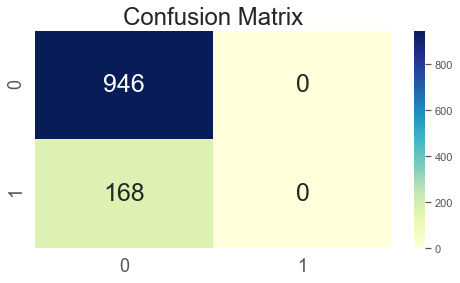

In [67]:
eva_valid2=EvaluateTest(yva.T, Y_prediction_Val2.T)

In [68]:
print("Train accuracy 2: {}".format(100 - np.mean(np.abs(Y_prediction_Train2 - ytr)) * 100))
print("Val accuracy 2: {}".format(100 - np.mean(np.abs(Y_prediction_Val2 - yva)) * 100))

Train accuracy 2: 87.1073885731379
Val accuracy 2: 84.91921005385997


# Test Model 

In [69]:
Y_prediction_Test, A_Test = predict(w, b, xte_norm)
print("Test accuracy: {}".format(100 - np.mean(np.abs(Y_prediction_Test - yte)) * 100))

Test accuracy: 95.87443946188341


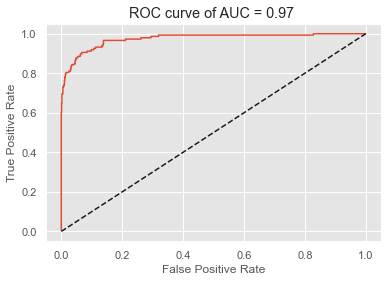

--> An AUC value of 0.97 achieved


In [70]:
compute_Roc(yte, A_Test)

--> The total of 1115 predicted with only 1069 accurate predictions

Ground Truth comparison

Actual label is True while we predicted True   -  True Positive  =  113
Actual label is False while we predicted False -  True Negatve   =  956
Actual label is False while we predicted True  -  False Positive =  11
Actual label is True while we predicted False  -  False Negative =  35


--> 124 positive outcomes predicted
--> 991 negative outcomes predicted
--> An accuracy of 95.87 % was achieved
--> Sensitity of 0.76 was achieved
--> Specificity of 0.99 was achieved 
--> 0.11 rate of positive prediction
--> 0.89 rate of negative prediction
--> 0.24 false negative rate was achieved
--> 0.01 false positve rate (fallout) was achieved
--> Negative predictive value of 0.96
--> Recall value 0f 0.76 achieved
--> The precision vaue of 0.91 achieved
--> An Fscore of 0.83 achieved


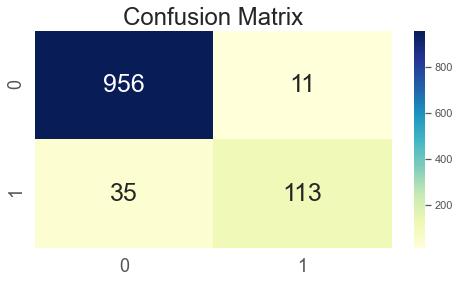

In [71]:
eva_test=EvaluateTest(yte.T, Y_prediction_Test.T)